In [1]:
import numpy as np
import copy
from meshpy.triangle import MeshInfo, build
import meshzoo
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import matplotlib.colors as mcolors
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import time
from IPython import display
import matplotlib.animation as animation
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
def ray_tracing_numpy(x,y,poly):
    val = False
    if len(np.shape(x)) == 0:
        val = True
        x = np.array([x])
        y = np.array([y])
    n = len(poly)
    inside = np.zeros(len(x),np.bool_)
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x,p1y = poly[0]
    for i in range(1,n+1):
        p2x,p2y = poly[i % n]
        idx = np.nonzero((y >= min(p1y,p2y)) & (y <= max(p1y,p2y)) & (x <= max(p1x,p2x)) )[0]
        if p1y != p2y:
            xints = (y[idx]-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
            if p1x == p2x:
                inside[idx] = ~inside[idx]
            else:
                idxx = idx[x[idx] <= xints]
                inside[idxx] = ~inside[idxx]    

        p1x,p1y = p2x,p2y
    if val:
        inside = inside[0]
    return inside 

In [3]:
def data_for_FMA(nodes, n):
    x_min = np.min(nodes[:,0])
    x_max = np.max(nodes[:,0])
    y_min = np.min(nodes[:,1])
    y_max = np.max(nodes[:,1])
    N = len(nodes)
    d = np.linalg.norm(nodes[N-1]-nodes[0])/(n*N)
    for i in range(N-1):
        d += np.linalg.norm(nodes[i+1]-nodes[i])/(n*N)
    Nx = 3 + int((x_max-x_min)/d)
    Ny = 3 + int((y_max-y_min)/d)
    array = -np.ones((Ny,Nx))
    for j in range(Ny):
        for i in range(Nx):
            x = x_min + (i-1)*d
            y = y_min + (j-1)*d
            if ray_tracing_numpy(x,y,nodes) and ray_tracing_numpy(x,y,np.flip(nodes, 0)):
                array[j,i] = 1
    #function = np.ones_like(array)/d
    return np.meshgrid(x_min-d+d*np.arange(Nx), y_min-d+d*np.arange(Ny)), array, d

In [4]:
class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = defaultdict(list)
        self.distances = {}

            
    def add_node(self, value):
        self.nodes.add(value)

    def add_edge(self, from_node, to_node, distance):
        if to_node not in self.edges[from_node]:
            self.edges[from_node].append(to_node)
            self.edges[to_node].append(from_node)
            self.distances[(from_node, to_node)] = distance
            self.distances[(to_node, from_node)] = distance
    def graph_from_nodes_and_cells(self, nodes, cells, connectivity = False, nodes_from = [], nodes_to = []):
        if connectivity:
            new_nodes = np.arange(len(nodes))
            new_nodes = np.delete(new_nodes, nodes_from)
            old_to_new_nodes = []
            #print(new_nodes)
            for i in range(len(nodes)):
                if i in nodes_from:
                    k = nodes_to[nodes_from.index(i)]
                else:
                    k = i
                old_to_new_nodes.append(np.where(new_nodes==k)[0][0])
            #print(old_to_new_nodes)
            for c in cells:
                self.add_node(old_to_new_nodes[c[0]])
                self.add_node(old_to_new_nodes[c[1]])
                self.add_node(old_to_new_nodes[c[2]])
                self.add_edge(old_to_new_nodes[c[0]],old_to_new_nodes[c[1]],np.linalg.norm(nodes[c[0]]-nodes[c[1]]))
                self.add_edge(old_to_new_nodes[c[0]],old_to_new_nodes[c[2]],np.linalg.norm(nodes[c[0]]-nodes[c[2]]))
                self.add_edge(old_to_new_nodes[c[1]],old_to_new_nodes[c[2]],np.linalg.norm(nodes[c[1]]-nodes[c[2]]))
            return old_to_new_nodes
            
        else:
            for c in cells:
                self.add_node(c[0])
                self.add_node(c[1])
                self.add_node(c[2])
                self.add_edge(c[0],c[1],np.linalg.norm(nodes[c[0]]-nodes[c[1]]))
                self.add_edge(c[0],c[2],np.linalg.norm(nodes[c[0]]-nodes[c[2]]))
                self.add_edge(c[1],c[2],np.linalg.norm(nodes[c[1]]-nodes[c[2]]))
    def graph_from_grid(self, array):
        initial = []
        s0 = array.shape[0]
        s1 = array.shape[1]
        for i in range(s0):
            for j in range(s1):
                if (i != 0 and i != s0-1 and array[i,j] == -1 and array[i-1,j]+ array[i+1,j] > -2) or (j != 0 and j !=  s1-1 and array[i,j] == -1 and array[i,j-1]+ array[i,j+1] > -2):
                    initial.append(i*s1+j)
                elif i == 0 and array[i,j] == -1 and array[i+1, j] == 1:
                    initial.append(i*s1+j)
                elif i == s0-1 and array[i,j] == -1 and array[i-1, j] == 1:
                    initial.append(i*s1+j)
                elif j == 0 and array[i,j] == -1 and array[i, j+1] == 1:
                    initial.append(i*s1+j)
                elif j == s1-1 and array[i,j] == -1 and array[i, j-1] == 1:
                    initial.append(i*s1+j)
                self.add_node(i*s1+j)
                if i != s0 -1:
                    self.add_edge(i*s1+j,(i+1)*s1+j,1)
                if j != s1 -1:
                    self.add_edge(i*s1+j,i*s1+j+1,1)
        return initial


def dijkstra(graph, initial, bound_nodes = [], voronoi = False):
    far = set(graph.nodes)
    accepted = {}
    path = {}
    considered = {}
    if voronoi:
        n_cells = len(initial)
        voronoi_cells = {}
    for j, init_node in enumerate(initial):
        if voronoi:
            #voronoi_cells[init_node] = [j]
            voronoi_cells[init_node] = j
        accepted[init_node] = 0
        far.remove(init_node)
        for edge in graph.edges[init_node]:
            if edge not in initial and edge not in considered.keys():
                considered[edge] = graph.distances[(init_node, edge)]
                far.remove(edge)
                path[edge] = init_node
                if voronoi:
                    #voronoi_cells[edge] = [j]
                    voronoi_cells[edge] = j
    #print(voronoi_cells)
    while considered:
        #print(far)
        #print(considered)
        #print(accepted)
        min_node = None
        for node in considered:
            if min_node is None:
                min_node = node
            elif considered[node] < considered[min_node]:
                min_node = node
        if min_node == None:
            break
        accepted[min_node] = considered[min_node]
        del considered[min_node]
        current_weight = accepted[min_node]
        
        
        
   
        for edge in graph.edges[min_node]:
            try:
                weight = current_weight + graph.distances[(min_node, edge)]
            except:
                weight = current_weight + math.inf
            if (edge not in considered.keys() or weight < considered[edge]) and edge not in accepted.keys() :
                considered[edge] = weight
                path[edge] = min_node
                if voronoi:
                    #print(voronoi_cells)
                    #print(min_node)
                    #print(edge)
                    #if edge in voronoi_cells  :
                    #    voronoi_cells[edge] = list(set(voronoi_cells[edge]).union(set(voronoi_cells[min_node])))
                    #else:
                    voronoi_cells[edge] = voronoi_cells[min_node]
                    
                if edge not in considered:
                    far.remove(edge)
            
        
        
    distances = []
    for i in range(len(accepted)):
        distances.append(accepted[i])
    
    if voronoi:
        return np.array(distances), voronoi_cells
    else:
        return np.array(distances)

In [5]:
def solve_quadric(vec):
    D = vec[1]**2 - 4*vec[2]*vec[0]
    if vec[2] == 0:
        array = np.array([-vec[0]/vec[1]])
        return 1, array
    elif D < 0:
        return 0, []
    elif D==0:
        array = np.array([-vec[1]/(2*vec[2])])
        return 1, array
    else:
        array = -vec[1]/(2*vec[2])*np.ones(2)
        array += np.array([np.sqrt(D)/(2*vec[2]), -np.sqrt(D)/(2*vec[2])])
        return 2, array

class Fast_marching_algorithm:
    def __init__(self, points, function = [], high_acc = True):
        if len(function) == 0:
            self._function = np.ones_like(points)
        else:
            self._function = function
        self._high_acc = high_acc
        self._points = np.array(points)
        self._s0 = np.shape(points)[0]
        self._s1 = np.shape(points)[1]
        self.compute_N4()
        self.construct_values()
        self.construct_state_and_heap()
        
    def construct_values(self):
        self._fm = np.finfo('d').max
        values = self._fm*np.ones_like(self._points)
        for i in range(self._s0):
            for j in range(self._s1):
                if (i != 0 and i != self._s0-1 and self._points[i,j] == -1 and self._points[i-1,j]+ self._points[i+1,j] > -2) or (j != 0 and j != self._s1-1 and self._points[i,j] == -1 and self._points[i,j-1]+ self._points[i,j+1] > -2):
                    values[i,j] = 0
                elif i == 0 and self._points[i,j] == -1 and self._points[i+1, j] == 1:
                    values[i,j] = 0
                elif i == self._s0-1 and self._points[i,j] == -1 and self._points[i-1, j] == 1:
                    values[i,j] = 0
                elif j == 0 and self._points[i,j] == -1 and self._points[i, j+1] == 1:
                    values[i,j] = 0
                elif j == self._s1-1 and self._points[i,j] == -1 and self._points[i, j-1] == 1:
                    values[i,j] = 0
        self._values = values
    def construct_state_and_heap(self):
        self._heap = {}
        self._state = 2*np.ones_like(self._values)
        self._state[self._values == 0] = 0
        for i in range(self._s0):
            for j in range(self._s1):
                if self._state[i,j] == 0:
                    for dire in self._N4:
                        i0 = int(i + dire[0])
                        j0 = int(j + dire[1])
                        if self.check_inside(i0, j0) and self._state[i0, j0] != 0:
                            self._state[i0, j0] = 1
                            comp = self.compute(i0, j0)
                            if comp[0]:
                                self._heap[i0*self._s1 + j0] = comp[1]
    def compute_N4(self):
        self._N4 = np.zeros((4,2))
        self._N4[0,0] = 1
        self._N4[1,0] = -1
        self._N4[2,1] = 1
        self._N4[3,1] = -1
    def check_inside(self, i, j):
        if i >= 0 and i <= self._s0-1 and j >= 0 and j <= self._s1-1:
            return True
        return False
    def compute(self, i, j):
        coef = np.array([-1.0/self._function[i,j]**2, 0, 0])
        pi = np.array([i,j])
        for k in range(2):
            val1 = self._fm
            val2 = self._fm
            for l in range(2):
                pni = (pi+self._N4[2*k+l]).astype(int)
                if self.check_inside(pni[0],pni[1]):
                    _val1 = self._values[pni[0],pni[1]]
                    if self._state[pni[0],pni[1]] == 0 and _val1 < val1:
                        val1 = _val1
                        pni2 =(pi + 2*self._N4[2*k+l]).astype(int)
                        if self.check_inside(pni2[0],pni2[1]):
                            _val2 = self._values[pni2[0], pni2[1]]
                            if self._state[pni2[0],pni2[1]] == 0 and _val2 <= _val1:
                                val2 = _val2
            if self._high_acc and val2 != self._fm:
                tp = (1/3)*(4*val1 - val2)
                a = 9/4
                coef += np.array([a*tp**2, - 2*a*tp, a])
            elif val1 != self._fm:
                coef += np.array([val1**2, -2*val1, 1])
        max_sol = self._fm
        sol = max_sol * np.ones(2)
        nb_sol, sol = solve_quadric(coef)
        if nb_sol:
            if nb_sol == 2:
                max_sol = np.max(sol)
            else:
                max_sol = sol[0]
            if max_sol < self._values[i,j]:
                self._values[i,j] = max_sol
                return [True, max_sol]
        return [False]
    def __call__(self):
        while len(self._heap) != 0:
            p = min(self._heap, key = self._heap.get)
            del self._heap[p]
            i = p//self._s1
            j = p%self._s1
            self._state[i, j] = 0
            for dire in self._N4:
                i0 = int(i + dire[0])
                j0 = int(j + dire[1])
                if self.check_inside(i0, j0) and self._state[i0,j0] != 0:
                    self._state[i0, j0] = 1
                    comp = self.compute(i0, j0)
                    if comp[0]:
                        self._heap[i0*self._s1 + j0] = comp[1]
                    
        return self._values

In [6]:
def create_polygon(n, r):
    alpha = np.pi*(n-2)/n
    beta = 0
    points = np.array([[0,0]])
    for i in range(n-1):
        points = np.append(points, [[points[-1,0] + r*np.cos(beta), points[-1,1] + r*np.sin(beta)]], axis = 0)
        beta+=np.pi-alpha
    return np.array(points)
def regular_polygon_mesh(points, k):
    n = len(points)
    centre = np.mean(points, axis = 0)
    nodes = []
    faces = []
    find_point = lambda i, j, l: int(n*(k - (i-1)/2)*i + j*(k-i) + l)
    for i in range(k):
        for j in range(n):
            if i > 0:
                if j == 0:
                    faces.append([find_point(i-1,0,0),find_point(i-1,n-1,k-i),find_point(i,j,0)])
                else:
                    faces.append([find_point(i-1,j-1,k-i),find_point(i-1,j,0),find_point(i,j,0)])
            for l in range(k-i):
                nodes.append(((k-i-l)*points[j] + l*points[(j+1)%n] + i*centre)/k)
                if i > 0:
                    faces.append([find_point(i-1,j,l),find_point(i-1,j,l+1),find_point(i,j,l)])
                    if j < n-1 or l < k-i-1:
                        faces.append([find_point(i-1,j,l+1),find_point(i,j,l),find_point(i,j,l+1)])
                    else:
                        faces.append([find_point(i-1,j,l+1),find_point(i,0,0),find_point(i,j,l)])

    nodes.append(centre)
    for j in range(n):
        if j < n-1:
            faces.append([n*k*(k+1)/2-n+j, n*k*(k+1)/2-n+(j+1), n*k*(k+1)/2 ])
        else:
            faces.append([n*k*(k+1)/2-n, n*k*(k+1)/2-1, n*k*(k+1)/2 ])
                 
    
    return np.array(nodes), np.int_(faces)

In [14]:
def find_closest_inner_nodes(points, nodes, k):
    centre = np.mean(points, axis = 0)
    inner_nodes = []
    n = len(nodes)
    find_point = lambda i, j, l: int(n*(k - (i-1)/2)*i + j*(k-i) + l)
    for p in points:
        for j in range(n):
            tr = np.array([nodes[j], nodes[(j+1)%len(nodes)], centre])
            if ray_tracing_numpy(p[0], p[1], tr):
                M = np.array([tr[0]-tr[2],tr[1]-tr[2]])
                t = p - tr[2]
                alpha = np.dot(np.dot(np.linalg.inv(np.dot(M, M.T)), M), t)
                #alpha = 0.5*np.dot(np.dot(np.linalg.inv(np.dot(tr, tr.T)), tr),p - 1/3*np.dot(p,np.ones(3))*np.ones(3))
                alpha = np.array([alpha[0], alpha[1], 1 - alpha[0]-alpha[1]])
                #print(np.dot(tr.T, alpha))
                alpha = np.int_(k*alpha)
                inner_nodes.append(find_point(alpha[2], j, alpha[1]))
                break
    return np.array(inner_nodes)
    
            
def Voronoi_iterations_reg_poly(n = 10, r = 1, num_clus = 2, mesh_f = 10, num_iter = 10):
    nodes = create_polygon(n, r)
    colors = np.ndarray(0)
    for i in range(num_clus):
        color = '#%06X' % np.random.randint(0, 0xFFFFFF)
        while color in colors:
            color = '#%06X' % np.random.randint(0, 0xFFFFFF)
        colors = np.append(colors, '#%06X' % np.random.randint(0, 0xFFFFFF))
    #inner_points = array_of_inner_points(nodes, n = num_clus)
    #fig, ax = plt.subplots()
    inner_nodes = np.random.randint(int(n*mesh_f*(mesh_f+1)/2+1), size = num_clus)
    while len(np.unique(inner_nodes)) != len(inner_nodes):
        inner_nodes = np.random.randint(int(n*mesh_f*(mesh_f+1)/2+1), size = num_clus)
    nodes_all, cells_all = regular_polygon_mesh(nodes,mesh_f)
    #print(inner_nodes)
    inner_points = nodes_all[inner_nodes]
    #print(cells_all)
    #print(len(nodes_all))
    #print(inner_points)
    
    
    g = Graph()
    g.graph_from_nodes_and_cells(nodes_all, cells_all)
    
    fig = plt.figure(figsize = (15,10))
    plt.title('Voronoi iterations')
    plt.xlim(np.min(nodes[:,0]),np.max(nodes[:,0]))
    plt.ylim(np.min(nodes[:,1]),np.max(nodes[:,1]))
    delay = 1.0
    
    
    
    p = PolygonPatch(Polygon(nodes), ec='blue', alpha = 0.2)
    plt.plot(inner_points[:,0], inner_points[:,1], 'r*', markersize=11)
    plt.gca().add_patch(p)
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(delay)
    
    for i in range(num_iter):
        plt.cla()
        #nodes_all, cells_all, boundary_nodes, inner_nodes = build_mesh(nodes, inner_points=inner_points, n=mesh_f)
        
        
        dij_dist, v_cells = dijkstra(g, inner_nodes, bound_nodes = nodes_all[:n*num_clus], voronoi = True)
        triang = mtri.Triangulation(nodes_all[:,0], nodes_all[:,1], cells_all)
        colorlevels = plt.tricontourf(triang, dij_dist)
        plt.triplot(triang, 'ko-', lw = 0.5, alpha=0.5, ms = 0.7)
        plt.plot(inner_points[:,0], inner_points[:,1], 'r*', markersize=11)
        plt.title('Voronoi iterations')
        plt.xlim(np.min(nodes_all[:,0]),np.max(nodes_all[:,0]))
        plt.ylim(np.min(nodes_all[:,1]),np.max(nodes_all[:,1]))
        plt.draw()
        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(delay)
        plt.cla()
        new_inner_points = np.zeros((num_clus, 2))
        num_tri = np.zeros(num_clus)
        

        for cell in cells_all:
            polygon = nodes_all[cell]
            dists = dij_dist[cell]
            min_node = cell[np.argmin(dists)]
            clus = v_cells[min_node]#[0]
            num_tri[clus] += 1
            new_inner_points[clus] += np.mean(nodes_all[cell], axis = 0)
            plt.fill(*zip(*polygon), alpha=0.4, c = colors[clus])
        new_inner_points = np.array([new_inner_points[i]/num_tri[i] for i in range(num_clus)]) 
        new_inner_nodes = find_closest_inner_nodes(new_inner_points, nodes, mesh_f)
        #print(new_inner_points[0])
        new_inner_points = nodes_all[new_inner_nodes]
        #print(new_inner_points[0])
        #time.sleep(5*delay)
        #for i in range(num_clus):
        #    if not ray_tracing_numpy(new_inner_points[i,0], new_inner_points[i,1], nodes):
        #        new_inner_points[i] = projection_on_mesh(new_inner_points[i], nodes_all, boundary_nodes)
        plt.plot(new_inner_points[:,0], new_inner_points[:,1], 'b*', markersize=11)
        plt.plot(inner_points[:,0], inner_points[:,1], 'r*', markersize=11)
        for i in range(num_clus):
            plt.arrow(inner_points[i,0],inner_points[i,1],new_inner_points[i,0] - inner_points[i,0], new_inner_points[i,1] - inner_points[i,1])
        plt.title('Voronoi iterations')
        vor = Voronoi(inner_points)
        voronoi_plot_2d(vor, ax = plt.gca())
        plt.xlim(np.min(nodes_all[:,0]),np.max(nodes_all[:,0]))
        plt.ylim(np.min(nodes_all[:,1]),np.max(nodes_all[:,1]))
        plt.draw()
        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(delay)
        if (np.mean(inner_points - new_inner_points))**2 < 10e-8:
            break
        inner_points = new_inner_points
        inner_nodes = new_inner_nodes
    
    
        
    
    display.clear_output()

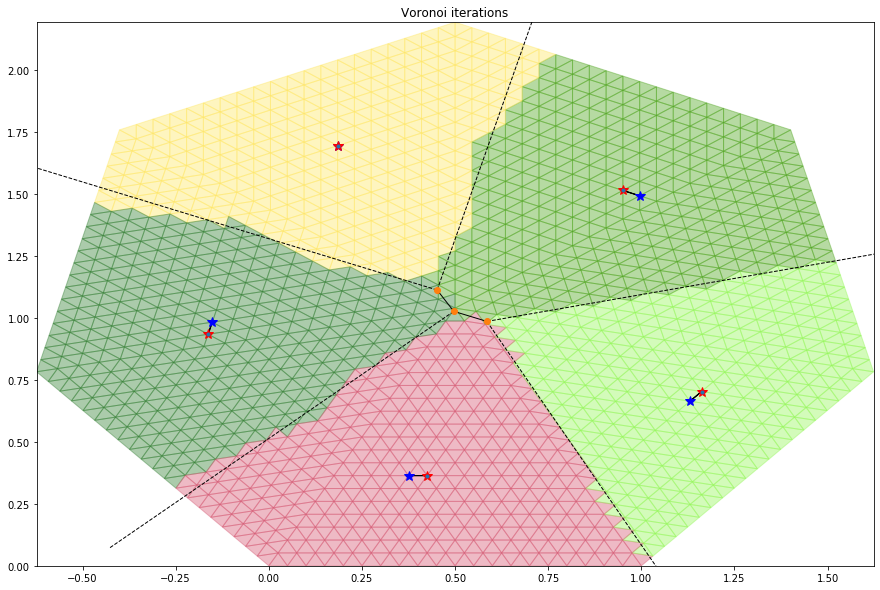

In [16]:
Voronoi_iterations_reg_poly(n = 7, r = 1, num_clus=5, mesh_f = 20, num_iter = 10)